In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
import glob, warnings, itertools
%matplotlib inline


In [422]:
path = r'C:\\Users\\jpisel\\Downloads\\pickups\\'
allFiles=glob.glob(path+"*.csv")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_csv(file, index_col=[0], parse_dates=[0], header=None)
    listed.append(df)
frame = pd.concat(listed)



In [4]:
frame.columns=['company']
frame['counts']=1

In [423]:
frame['lyft']=frame['company']=='Lyft'
frame['uber']=frame['company']=='Uber'
lyfted=frame.query('lyft == True ')
ubered=frame.query('uber == True')

KeyError: 'company'

In [ ]:
ubered.head()

In [5]:
new=frame.resample('d').sum()
new.head()

,counts
0,
2016-06-13,101
2016-06-14,134
2016-06-15,133
2016-06-16,140
2016-06-17,177


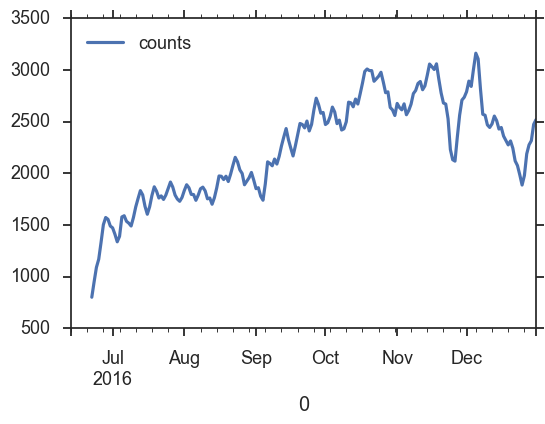

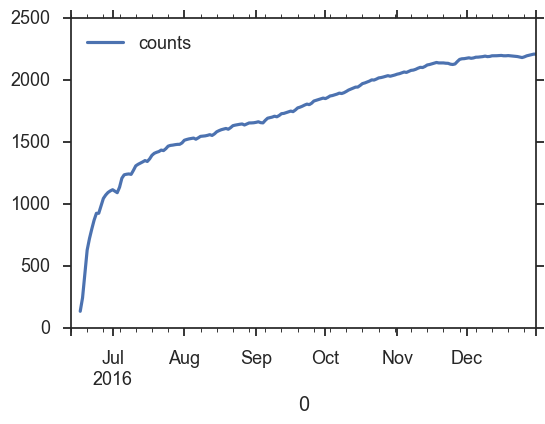

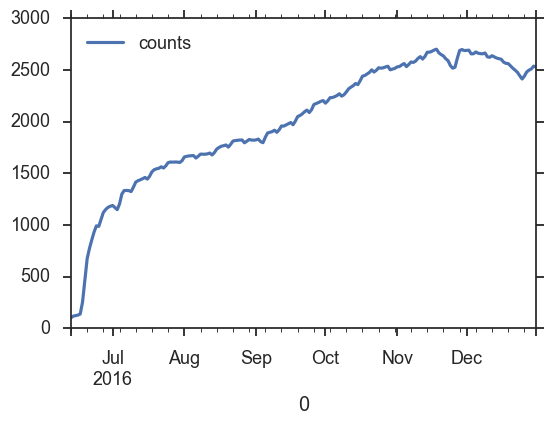

In [6]:
new.rolling(10).mean().plot(label='rolling')
new.expanding(5).mean().plot(label='expanding')
new.ewm(alpha=0.03).mean().plot(label='emwa')

In [7]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [15]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(new,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 7)12 - AIC:3409.3186290047533
ARIMA(0, 0, 0)x(0, 1, 1, 7)12 - AIC:2909.2365939596584
ARIMA(0, 0, 0)x(1, 0, 0, 7)12 - AIC:3123.976115810825
ARIMA(0, 0, 0)x(1, 0, 1, 7)12 - AIC:3032.373862471657
ARIMA(0, 0, 0)x(1, 1, 0, 7)12 - AIC:2938.1261853750666
ARIMA(0, 0, 0)x(1, 1, 1, 7)12 - AIC:2906.6615305303876
ARIMA(0, 0, 1)x(0, 0, 0, 7)12 - AIC:3455.1194473785117
ARIMA(0, 0, 1)x(0, 0, 1, 7)12 - AIC:3212.745782074723
ARIMA(0, 0, 1)x(0, 1, 0, 7)12 - AIC:2984.045907158082
ARIMA(0, 0, 1)x(0, 1, 1, 7)12 - AIC:2798.8090444206264
ARIMA(0, 0, 1)x(1, 0, 0, 7)12 - AIC:3020.246410393468
ARIMA(0, 0, 1)x(1, 0, 1, 7)12 - AIC:2913.2075492883487
ARIMA(0, 0, 1)x(1, 1, 0, 7)12 - AIC:2851.170369832912
ARIMA(0, 0, 1)x(1, 1, 1, 7)12 - AIC:2798.2265182437986
ARIMA(0, 1, 0)x(0, 0, 1, 7)12 - AIC:3050.0474437050048
ARIMA(0, 1, 0)x(0, 1, 1, 7)12 - AIC:2830.419548033302
ARIMA(0, 1, 0)x(1, 0, 0, 7)12 - AIC:3015.404303214701
ARIMA(0, 1, 0)x(1, 0, 1, 7)12 - AIC:2942.2504717154316
ARIMA(0, 1, 0)x(1,

In [16]:
mod = sm.tsa.statespace.SARIMAX(new, order=(1,1,1), seasonal_order=(0,1,1,7), 
                                enforce_stationarity=False, enforce_invertibility=False)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5890      0.046     12.749      0.000       0.498       0.680
ma.L1         -1.0340      0.020    -51.626      0.000      -1.073      -0.995
ma.S.L7       -1.1905      0.080    -14.955      0.000      -1.346      -1.034
sigma2      1.222e+05   1.18e+04     10.321      0.000     9.9e+04    1.45e+05


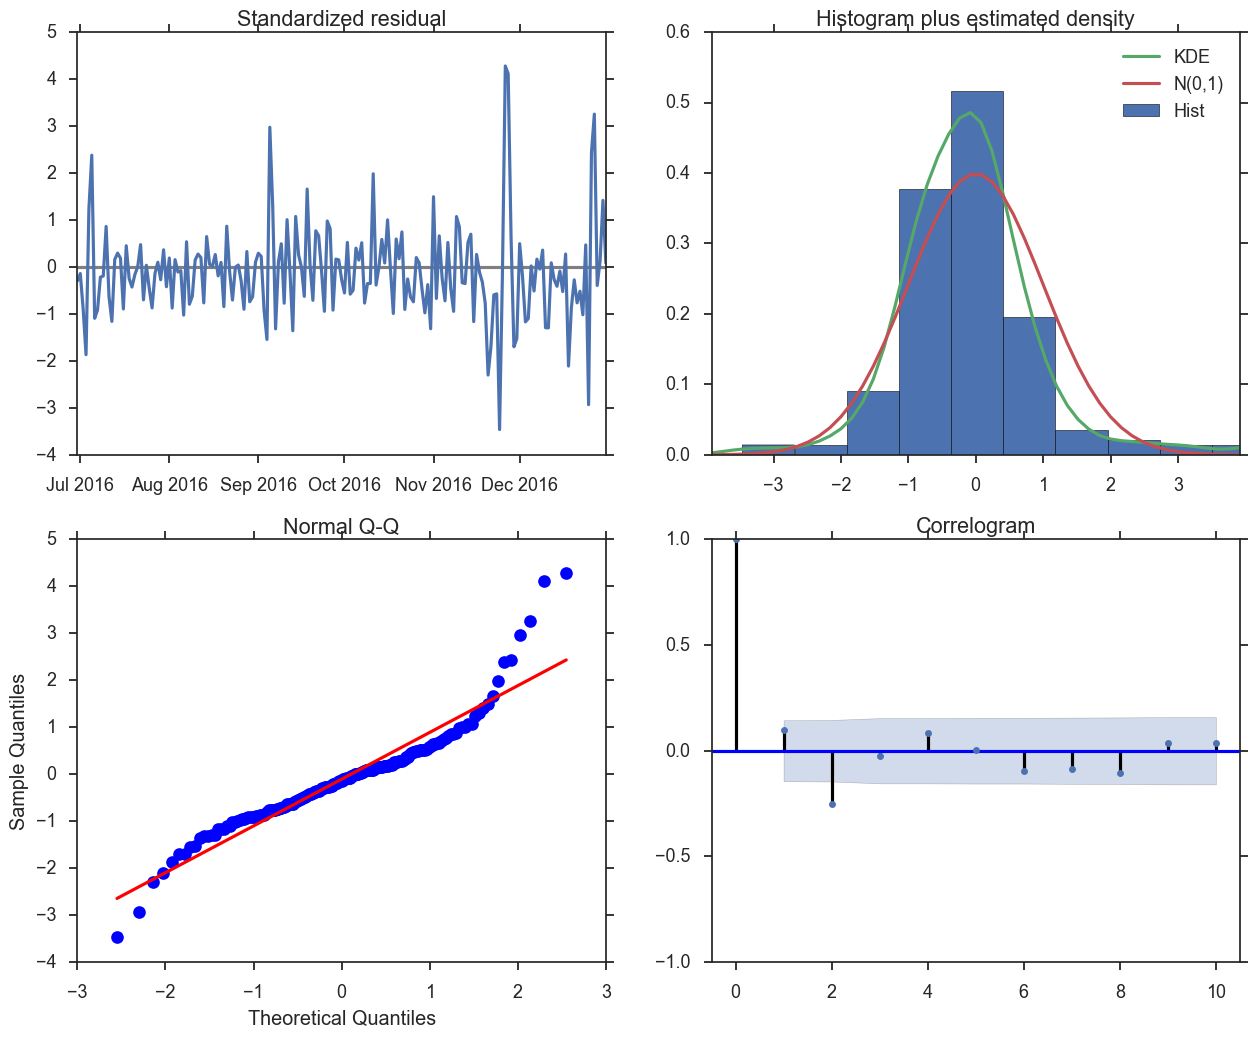

In [17]:
results = mod.fit()

print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [403]:
forecast_start='2016-11-01'
forecast_end='2016-12-31'
pred = results.get_prediction(start=forecast_start)
pred_ci = pred.conf_int()

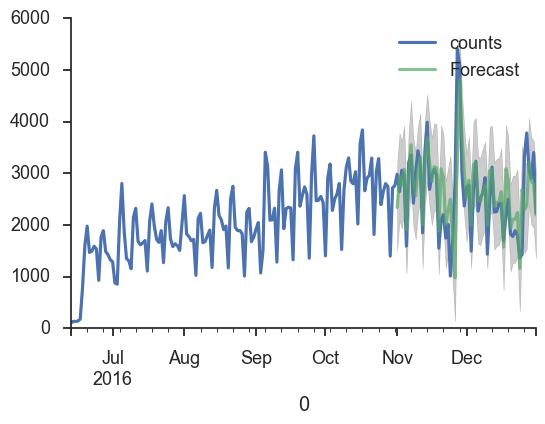

In [404]:
ax = new.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
sns.despine()

In [405]:
from sklearn import metrics
y_forecasted=pred.predicted_mean[forecast_start:forecast_end]
y_truth=new[forecast_start:forecast_end]
#Compute mean absolute error
metrics.mean_absolute_error(y_truth,y_forecasted)

410.68536360584756

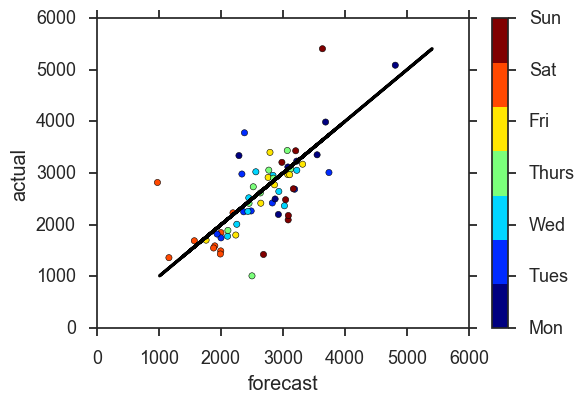

In [406]:
dayofweek = pd.to_datetime(y_forecasted.index).dayofweek

plt.scatter(y_forecasted,y_truth, c=dayofweek, cmap=plt.cm.get_cmap('jet', 7))
plt.plot(y_truth, y_truth,'k-') # identity line
plt.xlabel('forecast')
plt.ylabel('actual')
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

In [407]:
y_truth['counts'].idxmax()

Timestamp('2016-11-27 00:00:00', offset='D')

In [408]:
from pandas.tseries.holiday import USFederalHolidayCalendar
calen = USFederalHolidayCalendar()
holidays = calen.holidays('2016', '2017', return_name=True)

allholidays = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
allholidays = allholidays.sort_index()
allholidays.tail()

2016-11-24              Thanksgiving
2016-11-25    Day After Thanksgiving
2016-12-25      Day Before Christmas
2016-12-26                 Christmas
2016-12-27       Day After Christmas
dtype: object

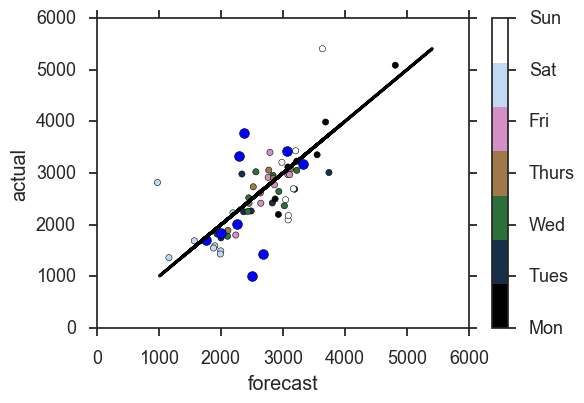

In [409]:
dates=allholidays.index
dayofweeks = pd.to_datetime(y_forecasted.index).dayofweek

plt.scatter(y_forecasted,y_truth, c=dayofweeks, cmap=plt.cm.get_cmap('cubehelix', 7))
plt.plot(y_truth, y_truth,'k-') # identity line
plt.xlabel('forecast')
plt.ylabel('actual')
dayofweeks = pd.to_datetime(y_forecasted.index).dayofweek
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

plt.scatter(y_forecasted.loc[dates], y_truth.loc[dates], c='b',s=50)


801.47059489317417

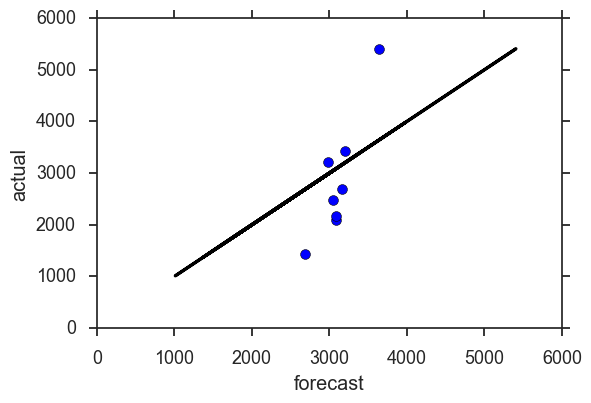

In [410]:
dazed=np.where(dayofweeks==6)
dates=allholidays.index
plt.plot(y_truth, y_truth,'k-') # identity line
plt.xlabel('forecast')
plt.ylabel('actual')
plt.scatter(y_forecasted.iloc[dazed], y_truth.iloc[dazed], c='b',s=50)
metrics.mean_absolute_error(y_truth.iloc[dazed], y_forecasted.iloc[dazed])

In [419]:
pred_dy = results.get_prediction(start='2016-07-01', dynamic=forecast_start)
pred_dy_ci = pred_dy.conf_int()

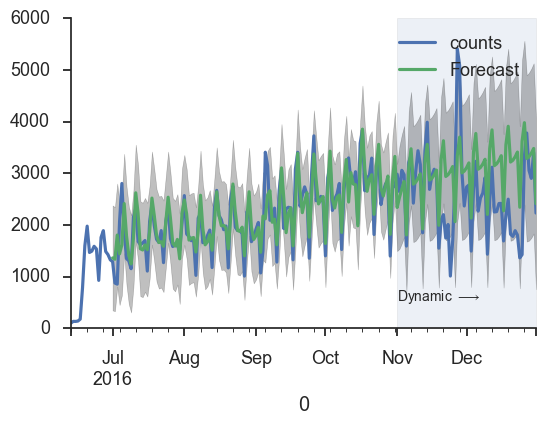

In [420]:
ax = new.plot(label='observed')
pred_dy.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_dy_ci.index,
                pred_dy_ci.iloc[:, 0],
                pred_dy_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.Timestamp(forecast_start), new.index[-1],
                 alpha=.1, zorder=-1)
ax.annotate('Dynamic $\\longrightarrow$', (pd.Timestamp(forecast_start), 550))

plt.legend()
sns.despine()